In [1]:
# Global imports and settings
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100 # Use 300 for PDF, 100 for slides
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Recap: Decision Trees
* Representation: Assume we can represent the concept we want to learn with a _decision tree_
    * Repeatedly split the data based on one feature at a time
    * Note: _Oblique trees_ can split on combinations of features
* Evaluation (loss): One tree is better that another tree according to some heuristic
    * Classification: Instances in a leaf are all of the same class (`pure` leafs)
    * Regression: Instances in a leaf have values close to each other
* Optimization: Recursive, heuristic greedy search (Hunt's algorithm)
    * Make first split based on the heuristic
    * In each branch, repeat splitting in the same way

#### Decision Tree classification
Where would you make the first split?

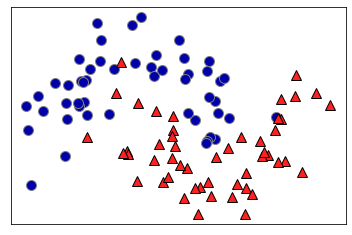

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
plt.figure()
ax = plt.gca()
mglearn.tools.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
ax.set_xticks(())
ax.set_yticks(());

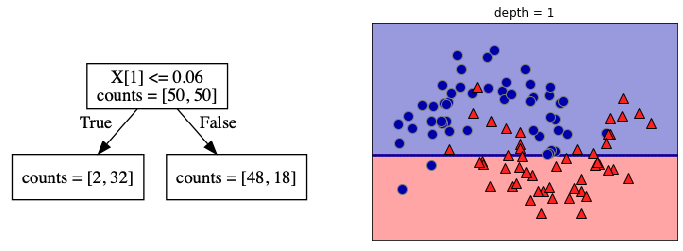

In [3]:
import graphviz
def plot_depth(depth):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                           subplot_kw={'xticks': (), 'yticks': ()})

    tree = mglearn.plots.plot_tree(X, y, max_depth=depth)
    ax[0].imshow(mglearn.plots.tree_image(tree))
    ax[0].set_axis_off()
plot_depth(1)

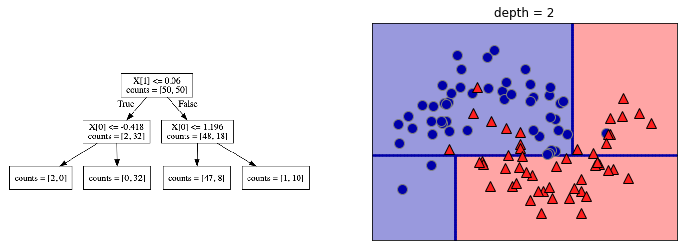

In [4]:
plot_depth(2)

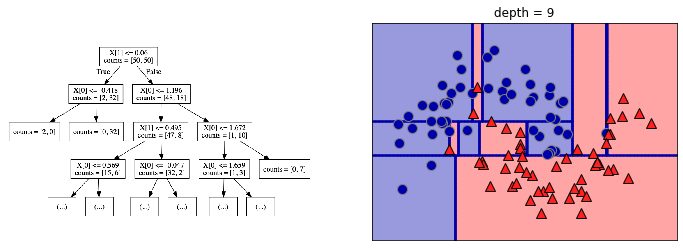

In [5]:
plot_depth(9)

### Heuristics
* We start from a dataset of $n$ points $D = \{(x_i,y_i)\}_{i=1}^{n}$ where $y_i$ is one of $k$ classes 
* Consider splits between adjacent data point of different class, for every variable
* After splitting, each leaf will have $\hat{p}_k$ = the relative frequency of class $k$

We can define several *impurity measures*:

- Misclassification Error (leads to larger trees):
$ 1 - \underset{k}{\operatorname{argmax}} \hat{p}_{k} $

- Gini-Index:
$ \sum_{k\neq k'} \hat{p}_k \hat{p}_{k'} = \sum_{k=1}^K \hat{p}_k(1-\hat{p}_k) $

- Sum up the heuristics per leaf, weighted by the number of examples in each leaf

$$ \sum_{l=1}^L \frac{|X_{i=l}|}{|X_{i}|} Gini(X_{i=l}) $$

Visualization: the plots on the right show the class distribution of the 'top' and 'bottom' leaf, respectively.

In [6]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def misclassification_error(leaf1_distr, leaf2_distr, leaf1_size, leaf2_size):
    total = leaf1_size + leaf2_size
    return leaf1_size/total * (1 - max(leaf1_distr)) + leaf2_size/total * (1 - max(leaf2_distr))

def gini_index(leaf1_distr, leaf2_distr, leaf1_size, leaf2_size):
    total = leaf1_size + leaf2_size
    return leaf1_size/total * np.array([leaf1_distr[k]*(1-leaf1_distr[k]) for k in range(0,2)]).sum() + \
            leaf2_size/total * np.array([leaf2_distr[k]*(1-leaf2_distr[k]) for k in range(0,2)]).sum()

@interact
def plot_heuristics(split=(-0.5,1.5,0.05)):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                           subplot_kw={'xticks': (), 'yticks': ()})
    mglearn.tools.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax[0])
    ax[0].plot([min(X[:, 0]),max(X[:, 0])],[split,split])

    ind = np.arange(2)
    width = 0.35
    top, bottom = y[np.where(X[:, 1]>split)], y[np.where(X[:, 1]<=split)]
    top_0, top_1 = (top == 0).sum()/len(top), (top == 1).sum()/len(top)
    bottom_0, bottom_1 = (bottom == 0).sum()/len(bottom), (bottom == 1).sum()/len(bottom)
    ax[1].barh(ind, [bottom_1,top_1], width, color='r')
    for i, v in enumerate([bottom_1,top_1]):
        ax[1].text(0, i, 'p_1={:.2f}'.format(v), color='black', fontweight='bold')
    ax[1].barh(ind+width, [bottom_0,top_0], width, color='royalblue')
    for i, v in enumerate([bottom_0,top_0]):
        ax[1].text(0, i + width, 'p_0={:.2f}'.format(v), color='black', fontweight='bold')
    error = misclassification_error([top_0,top_1],[bottom_0,bottom_1],len(top),len(bottom))
    gini = gini_index([top_0,top_1],[bottom_0,bottom_1],len(top),len(bottom))
    ax[1].set_title("Misclass. Error:{:.2f}, Gini:{:.2f}".format(error, gini))

interactive(children=(FloatSlider(value=0.5, description='split', max=1.5, min=-0.5, step=0.05), Output()), _d…

- Entropy (of the class attribute) measures *unpredictability* of the data:
    - How likely will random example have class k?
$$ E(X) = -\sum_{k=1}^K \hat{p}_k \log_{2}\hat{p}_k $$

- Information Gain (a.k.a. Kullback–Leibler divergence) measures how much entropy has reduced by splitting on attribute $X_i$:
$$ G(X,X_i) = E(X) - \sum_{l=1}^L \frac{|X_{i=l}|}{|X_{i}|} E(X_{i=l}) $$

with $X$ = the training set, $l$ a specific leaf after splitting on feature $X_i$, $X_{i=l}$ is the set of examples in leaf $l$: $\{x \in X | X_i \in l\}$

Heuristics visualized (binary class)
- Note that `gini != entropy/2`

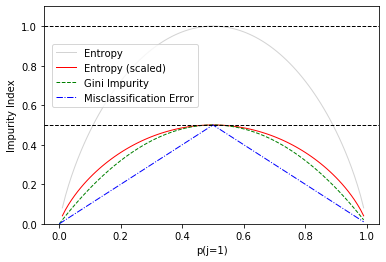

In [7]:
def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

### Example
Let's compute information gain for a dataset with categorical features:

Ex.| 1 | 2 | 3 | 4 | 5 | 6
---|---|---|---|---|---|---
a1 | T | T | T | F | F | F
a2 | T | T | F | F | T | T
class | + | + | - | + | - | -

$E(X)$ ?  
$G(X, X_{a2})$ ?  
$G(X, X_{a1})$ ?

$E(X)$ = $-(\frac{1}{2}*log_2(\frac{1}{2})+\frac{1}{2}*log_2(\frac{1}{2})) = 1$ (classes have equal probabilities)    
$G(X, X_{a2})$ = 0 (after split, classes still have equal probabilities, entropy stays 1)

Ex.| 1 | 2 | 3 | 4 | 5 | 6
---|---|---|---|---|---|---
a1 | T | T | T | F | F | F
a2 | T | T | F | F | T | T
class | + | + | - | + | - | -

$$ E(X) = -\sum_{k=1}^K \hat{p}_k \log\hat{p}_k \quad , \quad G(X,X_i) = E(X) - \sum_{v=1}^V \frac{|X_{i=v}|}{|X_{i}|} E(X_{i=v}) $$

$$E(X_{a1=T}) = - \frac{2}{3} \log_{2}(\frac{2}{3}) - \frac{1}{3} \log_{2}(\frac{1}{3}) = 0.9183 \quad (= E(X_{a1=F}))$$
$$G(X, X_{a1}) = 1 - \frac{1}{2} 0.9183 - \frac{1}{2} 0.9183 = 0.0817 $$

hence we split on a1

#### Heuristics in scikit-learn

The splitting criterion can be set with the `criterion` option in `DecisionTreeClassifier`

- `gini` (default): gini impurity index
- `entropy`: information gain

Best value depends on dataset, as well as other hyperparameters

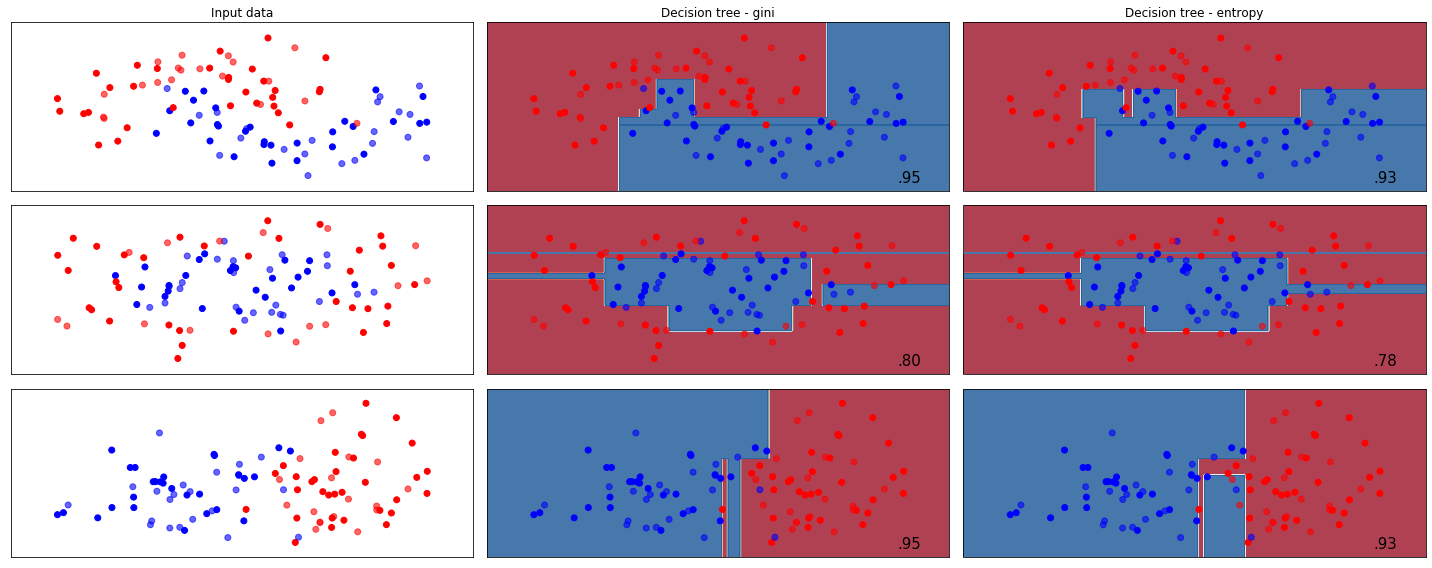

In [8]:
from sklearn.tree import DecisionTreeClassifier
import plot_classifiers as pc
names = ["Decision tree - gini", "Decision tree - entropy"]

classifiers = [
    DecisionTreeClassifier(),
    DecisionTreeClassifier(criterion="entropy")
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))

### Handling many-valued features
What happens when a categorical feature has (almost) as many values as examples?
- Information Gain will select it

One approach: use Gain Ratio instead (not available scikit-learn):
$$ GainRatio(X,X_i) = \frac{Gain(X,X_i)}{SplitInfo(X,X_i)}$$  
$$ SplitInfo(X,X_i) = - \sum_{v=1}^V \frac{|X_{i=v}|}{|X|} log_{2} \frac{|X_{i=v}|}{|X|} $$

where $X_{i=v}$ is the subset of examples for which feature $X_i$ has value v.

SplitInfo will be big if $X_i$ fragments the data into many small subsets, resulting in a smaller Gain Ratio. 

### Overfitting: Controlling complexity of Decision Trees
Decision trees can very easily overfit the data. Regularization strategies:  

* Pre-pruning: stop creation of new leafs at some point
    * Limiting the depth of the tree, or the number of leafs
    * Requiring a minimal leaf size (number of instances) to allow a split
* Post-pruning: build full tree, then prune (join) leafs
    * Reduced error pruning: evaluate against held-out data
    * Many other strategies exist. 
    * scikit-learn supports none of them (yet)

Effect of pre-pruning:
* Shallow trees tend to underfit (high bias)
* Deep trees tend to overfit (high variance)

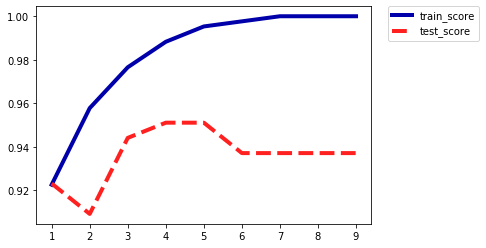

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
train_score, test_score = [],[]
for depth in range(1,10):
    tree = DecisionTreeClassifier(random_state=0, max_depth=depth).fit(X_train, y_train)
    train_score.append(tree.score(X_train, y_train))
    test_score.append(tree.score(X_test, y_test))
plt.plot(range(1,10), train_score, label="train_score", linewidth=4)
plt.plot(range(1,10), test_score, label="test_score", linewidth=4)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

Decision Trees are easy to interpet

- Visualize and find the path that most data takes

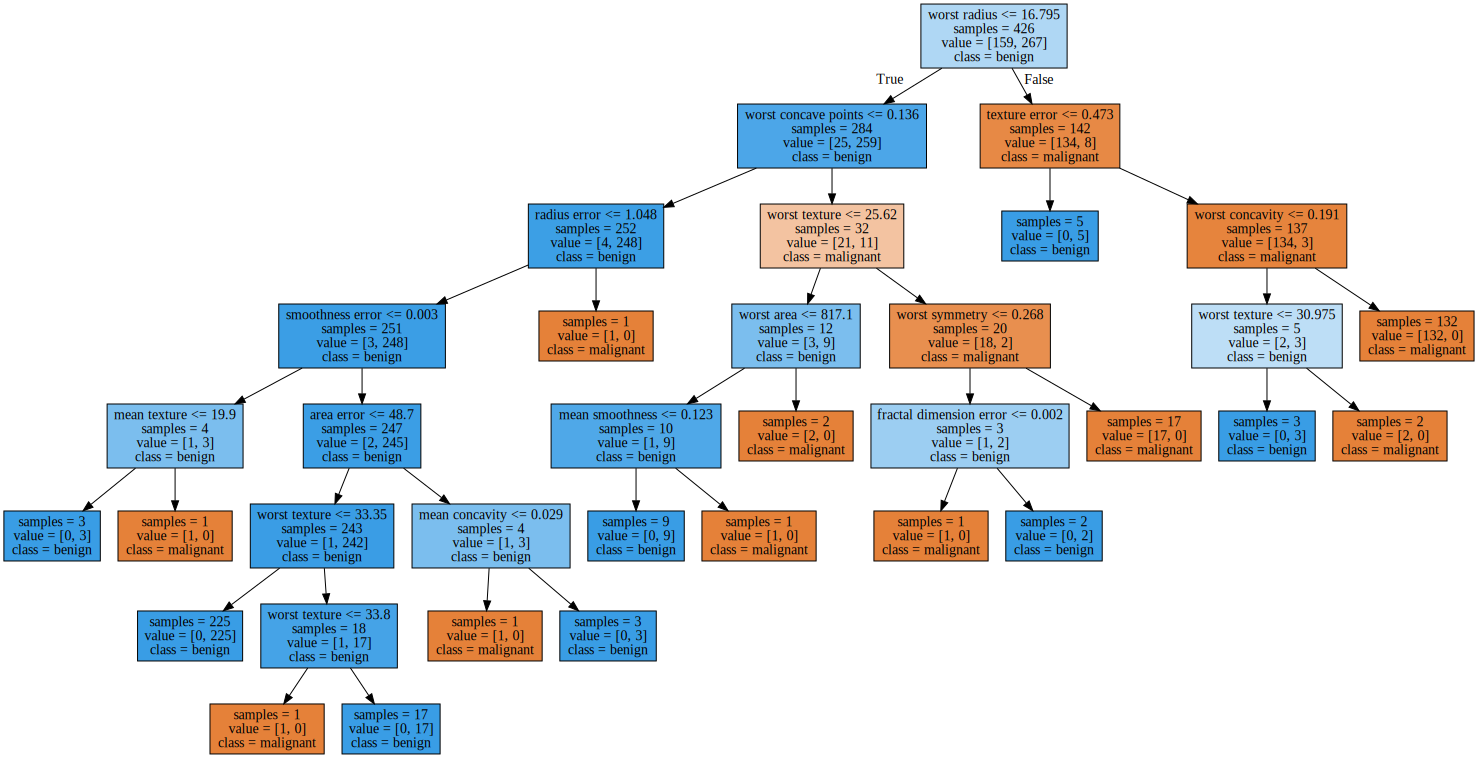

In [10]:
# Creates a .dot file
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"], 
                feature_names=cancer.feature_names, impurity=False, filled=True)
# Open and display
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

`DecisionTreeClassifier` also returns _feature importances_

``` python
tree.feature_importances_
```

* In [0,1], sum up to 1
* High values for features selected early (near the root)

In [11]:
# Feature importances sum up to 1
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.    0.008 0.    0.    0.009 0.    0.008 0.    0.    0.    0.01  0.046
 0.    0.002 0.002 0.    0.    0.    0.    0.007 0.695 0.054 0.    0.014
 0.    0.    0.017 0.117 0.011 0.   ]


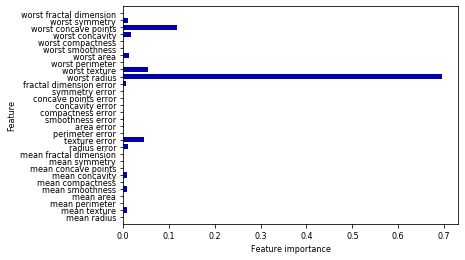

In [12]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.rcParams.update({'font.size': 8})
plot_feature_importances_cancer(tree)

### Decision tree regression
- Heuristic: *Minimal quadratic distance*
- Consider splits at every data point for every variable (or halfway between)
- Dividing the data on $X_j$ at splitpoint $s$ leads to the following half-spaces:

$$ R_1(j, s) = { X : X_j \leq s} \quad and \quad R_2(j, s) = { X : X_j > s} $$
    
- The best split, with predicted value $c_i$ (mean of all values in the leaf) and actual value $y_i$:

$$ \min_{j,s} \left(\min_{c_1} \sum_{x_{i} \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_{i} \in R_2(j,s)} (y_i - c_2)^2 \right) $$

- Assuming that the tree predicts $y_i$ as the average of all $x_i$ in the leaf:
    
$$ \hat{c}_1 = \text{avg}(y_i | x_{i} \in R_1(j,s)) \quad and \quad \hat{c}_2 = \text{avg}(y_i | x_{i} \in R_2(j,s)) $$

with $x_i$ being the i-th example in the data, with target value $y_i$

#### In scikit-learn
Regression is done with  `DecisionTreeRegressor`

In [13]:
def plot_decision_tree_regression(regr_1, regr_2):
    # Create a random dataset
    rng = np.random.RandomState(1)
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += 3 * (0.5 - rng.rand(16))

    # Fit regression model
    regr_1.fit(X, y)
    regr_2.fit(X, y)

    # Predict
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Plot the results
    plt.figure(figsize=(8,6))
    plt.scatter(X, y, c="darkorange", label="data")
    plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
    plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

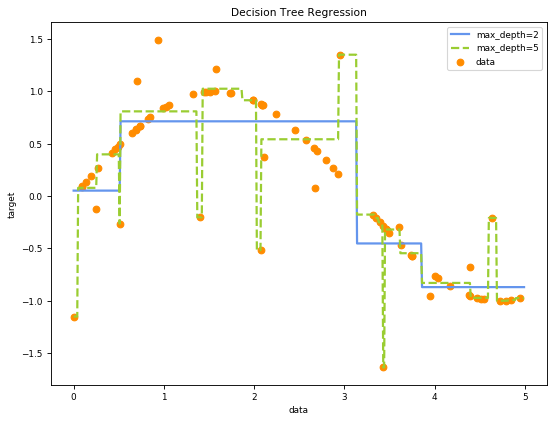

In [14]:
from sklearn.tree import DecisionTreeRegressor
plt.rcParams['figure.dpi'] = 80 
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)

plot_decision_tree_regression(regr_1,regr_2)

Note that decision trees do not extrapolate well. 

- The leafs return the same _mean_ value no matter how far the new data point lies from the training examples.
- Example on the `ram_price` forecasting dataset

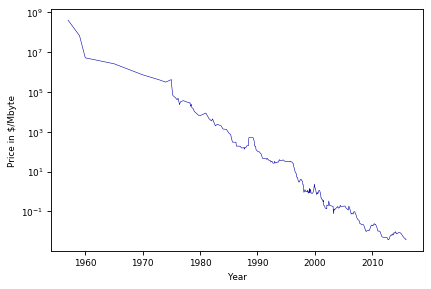

In [15]:
ram_prices = pd.read_csv('../data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

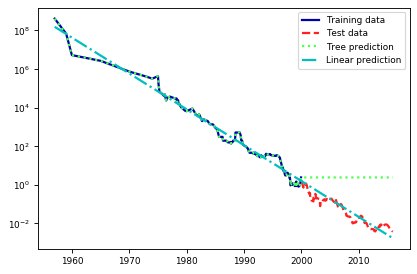

In [17]:
plt.rcParams['lines.linewidth'] = 2
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend();

### Model trees
* Instead of predicting a single value per leaf (e.g. mean value for regression), you can build a model on all the points remaining in a leaf
    * E.g. a linear regression model
* Can learn more complex concepts, extrapolates better. Overfits easily.
    

<img src="../images/04_model_trees.png" alt="ml" style="float: left; width: 60%;"/>

#### Strengths, weaknesses and parameters
Decision trees: 

* Work well with features on completely different scales, or a mix of binary and continuous features
    * Does not require normalization
* Interpretable, easily visualized
* Tend to overfit easily.

Pre-pruning: regularize by:

* Setting a low `max_depth`, `max_leaf_nodes`
* Setting a higher `min_samples_leaf` (default=1)

## On under- and overfitting
* Let's study which types of errors are made by decision trees
* Deep trees have high variance but low bias
    * What if we built many deep trees and average them out to reduce variance?
* Shallow trees have high bias but very low variance
    * What if we could correct the systematic mistakes to reduce bias?

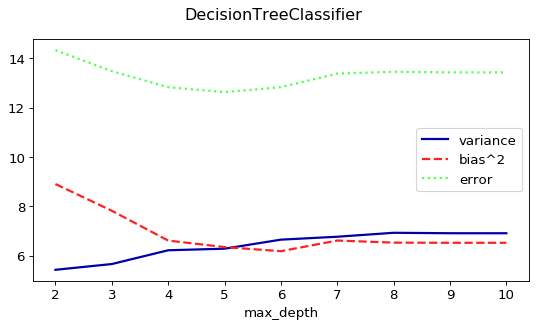

In [18]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

def plot_bias_variance(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    max_depth= range(2,11)

    for i in max_depth:
        b,v,e = compute_bias_variance(clf.set_params(random_state=0,max_depth=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(8,4))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)
    plt.plot(max_depth, var_scores,label ="variance" )
    plt.plot(max_depth, np.square(bias_scores),label ="bias^2")
    plt.plot(max_depth, err_scores,label ="error" )
    plt.xlabel("max_depth")
    plt.legend(loc="best")
    plt.show()

cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
dt = DecisionTreeClassifier()
plot_bias_variance(dt, X, y)

### Algorithm overview

| Name | Representation | Loss function | Optimization | Regularization |
|---|---|---|---|---|
| Classification trees | Decision tree | Information Gain (KL div.) / Gini index | Hunt's algorithm | Tree depth,... |
| Regression trees | Decision tree | Min. quadratic distance | Hunt's algorithm | Tree depth,... |
| Model trees | Decision tree + other models in leafs | As above + used model's loss | Hunt's algorithm + used model's optimization | Tree depth,... |